# Which Classifier is Should I Choose? 

This is one of the most import questions to ask when approaching a machine learning problem. I find it easier to just test them all at once. Here's 10 of your favorite Scikit-Learn algorithms applied to the leaf data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Preparation


In [2]:
# Swiss army knife function to organize the data

def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    test_ids = test.id                             # save test ids for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

train, labels, test, test_ids, classes = encode(train, test)
train.head(1)

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


## Stratified Train/Test Split

Stratification is necessary for this dataset because there is a relatively large number of classes (100 classes for 990 samples). This will ensure we have all classes represented in both the train and test indices. 

In [3]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=23)

for train_index, test_index in sss.split(train, labels):
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, #train w/o target var
                                                    target, 
                                                    test_size=0.20, 
                                                    random_state=1)

print("Records & variables in X_train dataset: ", X_train.shape)
print("Records in training dataset for Target variable: ", y_train.shape)
print("Records & variables in X_test dataset: ", X_test.shape)
print("Records in testing dataset for Target variable: ", y_test.shape)

## Sklearn Classifier Showdown

Simply looping through 10 out-of-the box classifiers and printing the results. Obviously, these will perform much better after tuning their hyperparameters, but this gives you a decent ballpark idea. 

In [4]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)


KNeighborsClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 1.5755075129933762
SVC
****Results****
Accuracy: 85.8586%
Log Loss: 4.641775801541843
NuSVC
****Results****
Accuracy: 92.9293%
Log Loss: 2.3934120064852324
DecisionTreeClassifier
****Results****
Accuracy: 65.1515%
Log Loss: 12.03624025883261
RandomForestClassifier
****Results****
Accuracy: 98.9899%
Log Loss: 0.7581760887160061
AdaBoostClassifier
****Results****
Accuracy: 4.5455%
Log Loss: 4.200034383188025
GradientBoostingClassifier
****Results****
Accuracy: 66.1616%
Log Loss: 2.135686742065486
GaussianNB
****Results****
Accuracy: 57.0707%
Log Loss: 14.827252492813216
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.9798%
Log Loss: 0.2299344821365325
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 2.5253%
Log Loss: 33.66658507180697


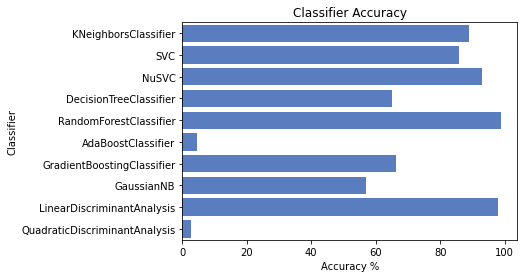

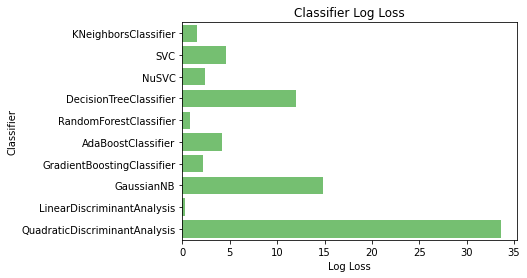

In [5]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

## Submission

After choosing your favorite classifier, format the output for a leaderboard submission. 

In [8]:
# Predict Test Set
favorite_clf = RandomForestClassifier()
favorite_clf.fit(X_train, y_train)
test_predictions = favorite_clf.predict_proba(test)

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()

# Export Submission
submission.to_csv('submission.csv', index = False)
submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.01,0.64,0.00,0.0,0.05,0.01,0.00,0.00,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.0,0.00
590,1577,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0.03,0.02,...,0.00,0.00,0.03,0.01,0.00,0.01,0.01,0.00,0.0,0.03
591,1579,0.02,0.02,0.00,0.0,0.04,0.02,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.00
592,1580,0.00,0.00,0.02,0.0,0.00,0.00,0.04,0.01,0.00,...,0.01,0.05,0.00,0.00,0.00,0.01,0.00,0.03,0.0,0.00
593,1583,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.02
